In [40]:
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.pipeline.data import Fundamentals
from quantopian.pipeline.data.builtin import USEquityPricing
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.optimize import TargetWeights
from quantopian.pipeline.factors import Returns


# The basics
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from collections import OrderedDict
from quantopian.research import run_pipeline

from alphalens.tears import create_information_tear_sheet
from alphalens.utils import get_clean_factor_and_forward_returns
import alphalens
import random as rd

In [41]:
num_holding_days = 5 # holding our stocks for five trading days.
days_for_fundamentals_analysis = 30
upper_percentile = 70
lower_percentile = 100 - upper_percentile

MAX_GROSS_EXPOSURE = 1.0
MAX_POSITION_CONCENTRATION = 0.05

MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 300

In [68]:
class Momentum(CustomFactor):
    # Default inputs
    inputs = [USEquityPricing.close]

    # Compute momentum
    def compute(self, today, assets, out, close):
        out[:] = close[-1] / close[0]
        
class Average_True_Range(CustomFactor):  
    inputs = [USEquityPricing.close, USEquityPricing.high, USEquityPricing.low]  
    window_length = 15  
    def compute(self, today, assets, out, close, high, low):  
        lb = self.window_length  
        atr = np.zeros(len(assets), dtype=np.float64)  
        a=np.array(([high[1:(lb)]-low[1:(lb)],abs(high[1:(lb)]-close[0:(lb-1)]),abs(low[1:(lb)]-close[0:(lb-1)])]))  
        b=a.T.max(axis=2)  
        c=b.sum(axis=1)  
        atr=c /(lb-1)

        out[:] = atr  

class Predictor(CustomFactor):
    """ Defines our machine learning model. """
    
    # The factors that we want to pass to the compute function. We use an ordered dict for clear labeling of our inputs.
    factor_dict = OrderedDict()
    factor_dict['Volume'] =USEquityPricing.volume
    factor_dict['earning_yield'] = Fundamentals.earning_yield
    factor_dict['cash_return'] = Fundamentals.cash_return
    factor_dict['Asset_Growth_2d'] = Returns(window_length=2)
    factor_dict['Asset_Growth_3d'] = Returns(window_length=3)
    factor_dict['Asset_Growth_4d'] = Returns(window_length=4)
    factor_dict['style_score'] = Fundamentals.style_score
    factor_dict['value_score'] = Fundamentals.value_score
    factor_dict['Return'] =  Returns(inputs=[USEquityPricing.open],window_length=5)
    
    columns = factor_dict.keys()
    inputs = factor_dict.values()

    # Run it.
    def compute(self, today, assets, out, *inputs):
        """ Through trial and error, I determined that each item in the input array comes in with rows as days and securities as columns. Most recent data is at the "-1" index. Oldest is at 0.

        !!Note!! In the below code, I'm making the somewhat peculiar choice  of "stacking" the data... you don't have to do that... it's just a design choice... in most cases you'll probably implement this without stacking the data.
        """

        ## Import Data and define y.
        inputs = OrderedDict([(self.columns[i],pd.DataFrame(inputs[i]).fillna(0,axis=1).fillna(0,axis=1)) for i in range(len(inputs))]) # bring in data with some null handling.
        num_secs = len(inputs['Return'].columns)
        y = inputs['Return'].shift(-num_holding_days)
        y=y.dropna(axis=0,how='all')
        
        for index, row in y.iterrows():
            
             upper = np.nanpercentile(row, upper_percentile)            
             lower = np.nanpercentile(row, lower_percentile)
             auxrow = np.zeros_like(row)
             
             for i in range(0,len(row)):
                if row[i] <= lower: 
                    auxrow[i] = -1
                elif row[i] >= upper: 
                    auxrow[i] = 1 
        
             y.iloc[index] = auxrow
            
        y=y.stack(dropna=False)
        
        
        ## Get rid of our y value as an input into our machine learning algorithm.
        #del inputs['Return']

        ## Munge x and y
        x = pd.concat([df.stack(dropna=False) for df in inputs.values()], axis=1).fillna(0)
        
        ## Run Model
        #model = GaussianNB() 
        model= DecisionTreeClassifier()
        model_x = x[:-num_secs*(num_holding_days)]
        model.fit(model_x, y)
        
        out[:] =  model.predict(x[-num_secs:])

def make_pipeline():
    universe = QTradableStocksUS()
    
    
    #============FACTORES=======================
    predicciones= Predictor(window_length=days_for_fundamentals_analysis, mask=universe)
    Momentum_10=Momentum(window_length=10)
    Average_True_Range_14=Average_True_Range(window_length=10)
    #===========================================
    
    FactorC=np.array([predicciones,Momentum_10,Average_True_Range_14])
    
    PesoFactor=np.array([[1,1,1],[2,1,2]])
                         
    combined_factor = ((FactorC*PesoFactor[0,:]).sum())
    
    
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    #The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)
    
    return Pipeline(columns={
            #'Model': predicciones,
            #'Momentum_10': Momentum_10,
            #'ATR_14': Average_True_Range_14,
            'Factor Combinado': combined_factor
        },screen = long_short_screen)


In [69]:
result = run_pipeline(make_pipeline(), '2015-05-05', '2015-05-05')
result.head()

Factor Combinado
2015-05-05 00:00:00+00:00 Equity(2 [ARNC])            0.384946
                          Equity(24 [AAPL])           5.192145
                          Equity(52 [ABM])            0.453878
                          Equity(166 [AES])           0.376786
                          Equity(368 [AMGN])          6.551194

In [70]:
result.shape

(300, 1)

In [71]:
factor_data = run_pipeline(make_pipeline(), '2019-08-06', '2020-02-02')
pricing_data = get_pricing(factor_data.index.levels[1], '2019-08-06', '2019-02-02', fields='open_price')
merged_data = get_clean_factor_and_forward_returns(factor_data, pricing_data)

InvalidDateRange: 
Supplied start_date is later than supplied end_date:
start_date=2019-08-06 00:00:00
end_date=2019-02-02 00:00:00

In [57]:
#alphalens.performance.factor_information_coefficient(merged_data).mean()
print(alphalens.performance.mean_information_coefficient(merged_data))
x=np.array(alphalens.performance.mean_information_coefficient(merged_data))
x[0]+x[1]

1D     0.042760
5D     0.089264
10D    0.108449
dtype: float64


0.13202330871727713

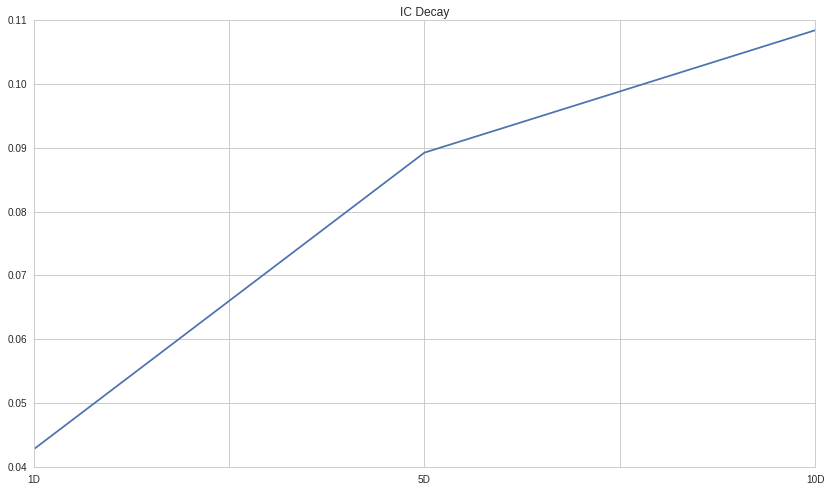

In [62]:
from alphalens.utils import get_clean_factor_and_forward_returns
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(merged_data).plot(title="IC Decay")

In [64]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2013-1-1', 
    end_date='2014-1-1' #  *** NOTE *** Our factor data ends in 2014
)

pricing_data = get_pricing(
    pipeline_output.index.levels[1], 
    start_date='2013-1-1',
    end_date='2015-2-1', # *** NOTE *** Our pricing data ends in 2015
    fields='open_price'
)

factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['factor_to_analyze'], 
    pricing_data,
    periods=range(1,252,20) # Change the step to 10 or more for long look forward periods to save time
)

mean_information_coefficient(factor_data).plot()

KeyError: 'factor_to_analyze'

In [ ]:
from alphalens.tears import create_returns_tear_sheet

sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output['factor_to_analyze'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
)

create_returns_tear_sheet(factor_data=factor_data, by_group=True)